<a href="https://colab.research.google.com/github/BriouaNorElHouda/py/blob/main/landv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import requests
import os
import io
import cv2
import shutil
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import time

In [ ]:
zip_path = '/content/drive/MyDrive/Colab Notebooks/EuroSatDS.zip'

extracted_path = "/content/EuroSatDS"
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extracted_path)
data = []

src_path = os.path.join(extracted_path, "EuroSatDS")
subclass = os.listdir(src_path)

def create_data():
    for sclass in subclass:
        path = os.path.join(src_path, sclass)
        class_num = subclass.index(sclass)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (224, 224))
            data.append([new_array, class_num])

create_data()
print("Total samples in the dataset:", len(data))

100%|██████████| 2500/2500 [00:00<00:00, 3292.45it/s]

Total samples in the dataset: 22000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


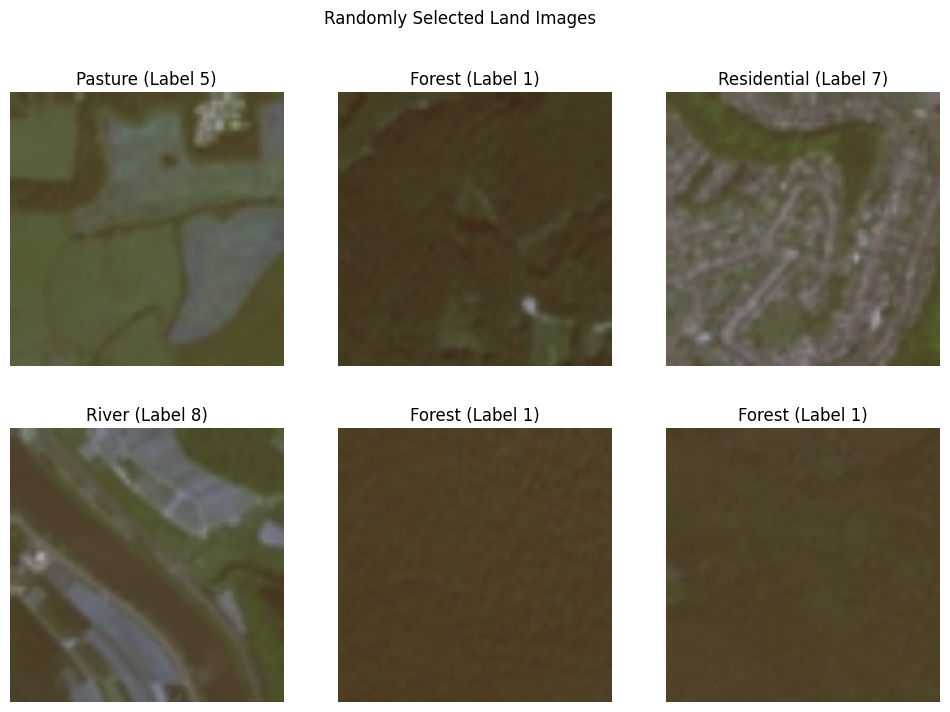

In [ ]:
import random
types = {'AnnualCrop': 0,
         'Forest': 1,
          'HerbaceousVegetation': 2,
          'Highway': 3,
          'Industrial': 4,
          'Pasture': 5,
          'PermanentCrop': 6,
          'Residential': 7,
          'River': 8,
          'SeaLake': 9,
          }

image_files = []
for root, dirs, files in os.walk(src_path):
    for file in files:
        if file.endswith(".jpg"):
            image_files.append((os.path.join(root, file), os.path.basename(root)))

random_images = random.sample(image_files, 6)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Randomly Selected Land Images')

for i, (image_file, land_name) in enumerate(random_images):
    img_array = cv2.imread(image_file, cv2.IMREAD_COLOR)
    new_array = cv2.resize(img_array, (224, 224))

    row_index = i // 3
    col_index = i % 3

    label_number = types[land_name]
    axes[row_index, col_index].imshow(new_array,  cmap=None)
    axes[row_index, col_index].set_title(f'{land_name} (Label {label_number})')
    axes[row_index, col_index].axis('off')

plt.show()

In [ ]:

X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class MyDataGenerator(keras.utils.Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.num_samples = len(X)

    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, self.num_samples)

        batch_X = self.X[start:end]
        batch_y = self.y[start:end]

        batch_X = np.array(batch_X).reshape(-1, 224, 224, 3) / 255.0
        batch_y = np.array(batch_y)

        return batch_X, batch_y

batch_size = 32
train_generator = MyDataGenerator(X_train, y_train, batch_size)
test_generator = MyDataGenerator(X_test, y_test, batch_size)


In [ ]:
NAME="Model1"

model=Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),  activation='relu',  input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

tensorboard= TensorBoard(log_dir="logs\{}".format(NAME))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=5,batch_size=32, validation_data=test_generator,callbacks=[tensorboard])

Epoch 1/5
550/550 [==============================] - 43s 65ms/step - loss: 1.3421 - accuracy: 0.4869 - val_loss: 0.9220 - val_accuracy: 0.6580
Epoch 2/5
550/550 [==============================] - 35s 64ms/step - loss: 0.7983 - accuracy: 0.7136 - val_loss: 0.6511 - val_accuracy: 0.7593
Epoch 3/5
550/550 [==============================] - 35s 63ms/step - loss: 0.6362 - accuracy: 0.7648 - val_loss: 0.5483 - val_accuracy: 0.8050
Epoch 4/5
550/550 [==============================] - 35s 63ms/step - loss: 0.5194 - accuracy: 0.8127 - val_loss: 0.6922 - val_accuracy: 0.7561
Epoch 5/5
550/550 [==============================] - 35s 63ms/step - loss: 0.4402 - accuracy: 0.8417 - val_loss: 0.4634 - val_accuracy: 0.8414


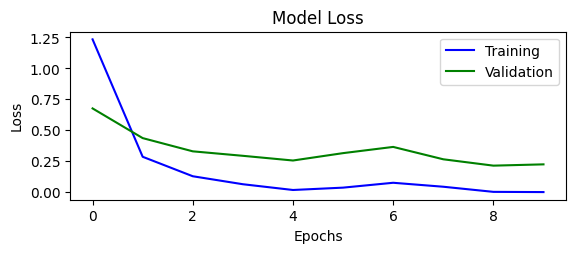

In [ ]:
#Plot Model Loss
plt.subplot(211)
plt.title('Model Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='green', label='test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'],loc='upper right')

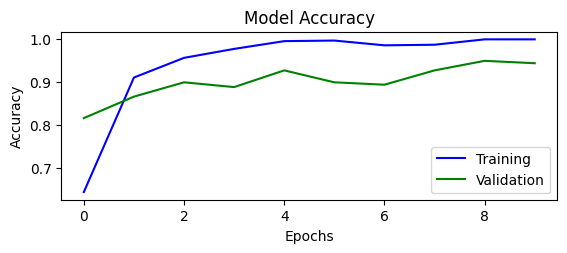

In [ ]:
# Plot Accuracy
plt.subplot(211)
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='green', label='test')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'],loc='lower right')

In [ ]:
model.save("land.h5")

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 112, 112, 32)      320       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 54, 54, 32)        0         
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 25, 25, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 20000)             0         
                                                                 
 dense_12 (Dense)            (None, 15)              

In [ ]:
#Testing predictions on model
from tensorflow.keras.preprocessing import image

def prediction(img):
    img = image.img_to_array(img)
    img = img.reshape(-1, 224, 224, 1)
    img = img.astype('float32')
    img = img/255.0

    return np.argmax(model.predict(img),axis=-1)[0]

labels=["AnnualCrop","Forest","HerbaceousVegetation","Highway","Industrial","Pasture","PermanentCrop", "Residential","River","SeaLake"]
path = "/content/image.tif.png"
img = image.load_img(path,target_size=(224,224),grayscale=True)
print(labels[prediction(img)])

/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


NameError: name 'model' is not defined

In [ ]:
folder_to_delete = '/content/2750'

# Delete the folder and all its contents
shutil.rmtree(folder_to_delete)


In [ ]:

url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
data = []
src_path = "./2750"

subclass = os.listdir(src_path)

def create_data():
    for sclass in subclass:
        path = os.path.join(src_path, sclass)
        class_num = subclass.index(sclass)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (224, 224))
            data.append([new_array, class_num])

create_data()
print("Total samples in the dataset:", len(data))

100%|██████████| 3000/3000 [00:00<00:00, 6402.55it/s]

Total samples in the dataset: 27000
